#Transfer Learning with TensorFlow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learning patterns for our own problem.


There are 2 main benefits:
1. can leveraging an exisiting neural network architecture proven to work on problems simiar to our  own.
2. can leveraging a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
!nvidia-smi

Sat Apr 22 06:20:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with our data

In [2]:
#get data (10% of 10 food classes from food 101)

import zipfile

#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-04-22 06:20:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.7MB/s    in 8.5s    

2023-04-22 06:20:58 (18.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [14]:
#how many images in each folder?
import os
#walk through 10 percent data directory and list number of files
for dirpath , dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

there are 2 directories and 0 images in '10_food_classes_10_percent' .
there are 10 directories and 0 images in '10_food_classes_10_percent/train' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza' .
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry' .
there are 0 directories and 75 images in '10_food_classes_10_

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
#setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")


print("testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after Training. Some of the most popular callbacks:

* Training experiments with the TensorBoard callback
* Model Checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [5]:
import tensorflow as tf

In [6]:
#create tensorboard callback (functionlize because we need to create a new one for each model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"saving tensorboard log files to: {log_dir}")
  return tensorboard_callback

#creating model using tensorflow hub

In the past we've used tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [7]:
#let's compare the follow 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [8]:
#import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [10]:
#let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.


  Args: 
    mode_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default 10.

  returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.


  """

  #Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False,#freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,)) 
  

  #create our own model

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model


###Creating ResNet TensorFlow Hub Feature Extraction model

In [11]:
#Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [12]:
#compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics="accuracy")

In [17]:
#fit our resnet model to the data (10 of the data)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  callbacks = create_tensorboard_callback("log","resnet_model"),
                                  validation_data = test_data,
                                  validation_steps = len(test_data))

saving tensorboard log files to: log/resnet_model/20230422-062541
Epoch 1/5
24/24 [==============================] - 33s 871ms/step - loss: 2.0759 - accuracy: 0.3187 - val_loss: 1.2479 - val_accuracy: 0.5868
Epoch 2/5
24/24 [==============================] - 18s 768ms/step - loss: 0.9582 - accuracy: 0.6893 - val_loss: 0.8722 - val_accuracy: 0.7156
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6517 - accuracy: 0.8093 - val_loss: 0.7516 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 18s 754ms/step - loss: 0.5022 - accuracy: 0.8707 - val_loss: 0.7159 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 19s 795ms/step - loss: 0.4008 - accuracy: 0.9093 - val_loss: 0.6744 - val_accuracy: 0.7824


Wow!

That is incrediable. Our transfer learning feature extractor model out performed all of the previous models we built by hand... (substantially) and in a quicker training time.
And with only 10% of the availabel training data

In [18]:
import matplotlib.pyplot as plt

In [23]:
#let's create a function to plot our loss curves 
#tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
#from helper import plot_loss_curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """


  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epoch = range(len(history.history["loss"]))

  plt.plot(epoch, loss, label ="training_loss")
  plt.plot(epoch, val_loss, label = "validation_loss")
  plt.xlabel = "epochs"
  plt.title("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epoch, accuracy, label = "training_accuracy")
  plt.plot(epoch, val_accuracy, label = "validation_accuracy")
  plt.xlabel = "epochs"
  plt.title("Accuracy")
  plt.legend()

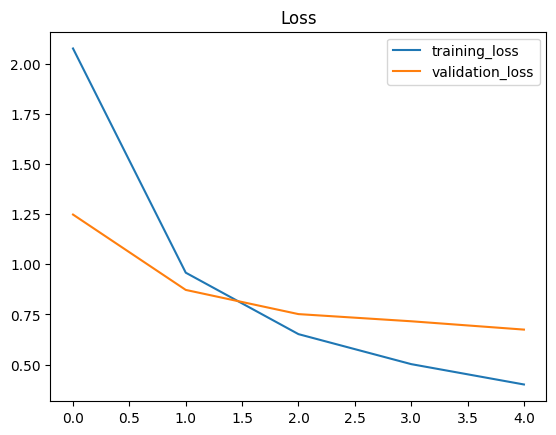

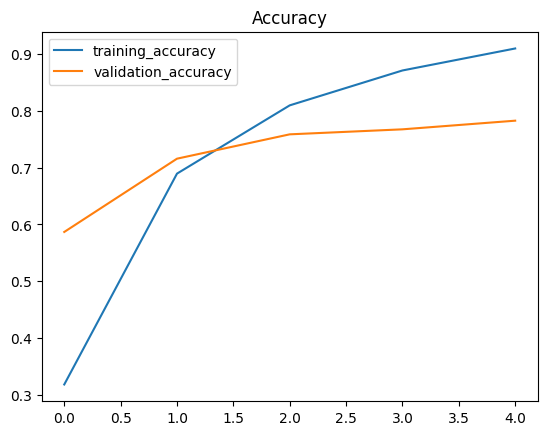

In [24]:
plot_loss_curves(resnet_history)

###Creating EfficientNet TensorFlow Hub Feature Extraction model

In [26]:
#create the model
effnet_model = create_model(efficientnet_url)

#compile the model 
effnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])



In [27]:
#fit the model
effnet_history = effnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  callbacks = [create_tensorboard_callback("log","effnet_model")],
                                  validation_data = test_data,
                                  validation_steps = len(test_data))

saving tensorboard log files to: log/effnet_model/20230422-071508
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.7866 - accuracy: 0.4600 - val_loss: 1.2444 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 17s 739ms/step - loss: 1.0385 - accuracy: 0.7693 - val_loss: 0.8498 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 21s 892ms/step - loss: 0.7472 - accuracy: 0.8267 - val_loss: 0.6873 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 17s 749ms/step - loss: 0.6006 - accuracy: 0.8693 - val_loss: 0.6034 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 18s 764ms/step - loss: 0.5079 - accuracy: 0.8933 - val_loss: 0.5516 - val_accuracy: 0.8580


In [29]:
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/10_food_classes_10_percent/test")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [31]:
def load_and_prep_image(filename, img_shape=224):
 """
 read an image from file name, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels)
 """

 #read in the image
 img = tf.io.read_file(filename)
 #decode the read file into a tensor
 img = tf.image.decode_image(img)
 #resize the image
 img = tf.image.resize(img, size = [img_shape, img_shape])
 #rescale the image and get all values between 0 and 1
 img= img/255.
 #expand the dimension of the img to include the batch size
 img = tf.expand_dims(img, axis = 0)
 return img

In [35]:
#reconfig pred_and_plot function to maje it work with multiclass
def pred_and_plot(model, filename, class_names = class_names):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the 
  predicted class as the title.
  """

  #import the target image and preprocessed it
  img = load_and_prep_image(filename)

  #make a prediction
  pred = model.predict(img)

  #add in logic for multiclass and get pre_clasname
  if(len(pred[0])>1):
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    #get the predicted class
    pred_class = class_names[int(tf.round(pred))]
  

  #plot the image and predicted class
  plt.imshow(tf.squeeze(img))
  plt.title(f"prediction:{pred_class}")
  plt.axis(False)

In [42]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2023-04-22 07:31:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1725178 (1.6M) [image/jpeg]
Saving to: ‘03-sushi.jpeg’

03-sushi.jpeg       100%[===================>]   1.64M  --.-KB/s    in 0.008s  

2023-04-22 07:31:36 (202 MB/s) - ‘03-sushi.jpeg’ saved [1725178/1725178]



1/1 [==============================] - 0s 29ms/step


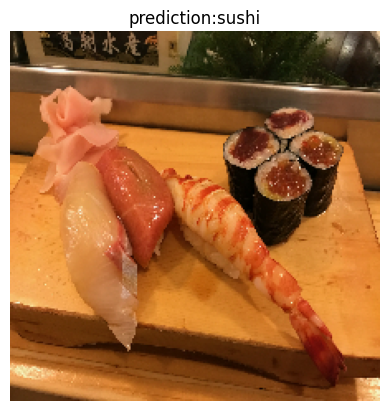

In [43]:
pred_and_plot(effnet_model, "03-sushi.jpeg" )

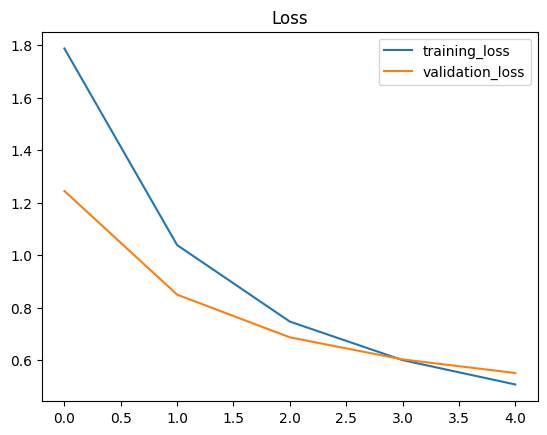

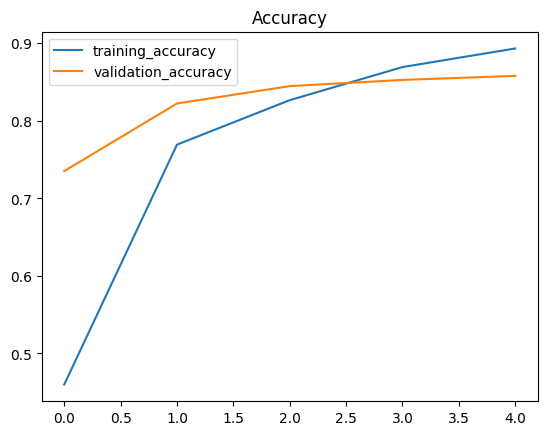

In [44]:
plot_loss_curves(effnet_history)

In [45]:
effnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [46]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [50]:
#how many layers does our efficientnet b0 feature extractor have?
len(effnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** -using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned pattern of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes from ImageNet to 10 to this problem)
* **"Fine-tunning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

### Comparing our models' results using TensorBoard 
>**Note:** when you upload things to TensorBoard.dev => your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to tensorboard.dev

In [58]:
#upload tensorboard dev records
!tensorboard dev upload --logdir ./log/ --name "EfficientNetB0 vs. ResNet50V2" --description "Camparing 2 different TF Hub feature extraction model architecture using 10% of the training data" --one_shot

2023-04-22 08:13:41.585155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./log/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   KDH-RNT-WKZ



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Dh

In [59]:
#Check out what tensorboard experiments you have
!tensorboard dev list

2023-04-22 08:19:57.375397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/DhV3OZfNQpmpJlLONLqzJg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Camparing 2 different TF Hub feature extraction model architecture using 10% of the training data
	Id                   DhV3OZfNQpmpJlLONLqzJg
	Created              2023-04-22 08:15:10 (4 minutes ago)
	Updated              2023-04-22 08:15:15 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811189
Total: 1 experiment(s)


In [60]:
#delete an experiment
# !tensorboard dev delete--experiment_id DhV3OZfNQpmpJlLONLqzJg

In [61]:
#confirm the deletion by rechecking what experiment you have left
!tensorboard dev list

2023-04-22 08:21:44.719275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/DhV3OZfNQpmpJlLONLqzJg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Camparing 2 different TF Hub feature extraction model architecture using 10% of the training data
	Id                   DhV3OZfNQpmpJlLONLqzJg
	Created              2023-04-22 08:15:10 (6 minutes ago)
	Updated              2023-04-22 08:15:15 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811189
Total: 1 experiment(s)
